In [1]:
import pandas as pd
from scipy.io import loadmat
from dtaidistance import dtw_ndim
from dtaidistance import dtw_ndim_visualisation
from tqdm import tqdm
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn import metrics

In [21]:
data_m= loadmat("../../VMT_dataset/CASIA_tjc.mat")
tracks = data_m["tjc"]
tracks = np.delete(tracks, list(range(0, 1500, 3)) + list(range(1, 1500, 3)), axis=0)
for i in range(tracks.shape[0]):
    tracks[i][0] = tracks[i][0].transpose([1, 0])
tracks=tracks.reshape(-1)[:500]
labels_true = data_m["labels"][:, 0]#.reshape(1, -1)
labels_true = np.delete(labels_true, list(range(0, 1500, 3)) + list(range(1, 1500, 3)), axis=0)
labels_true = labels_true.flatten()[:500]
print(tracks.shape)
print(labels_true.shape)
print(tracks[-1].shape)

(500,)
(500,)
(2, 369)


In [3]:
#计算并保存所有track之间的dtw距离矩阵
dis_mat = np.zeros([tracks.shape[0], tracks.shape[0]])
with tqdm(total=tracks.shape[0]) as bar:
    for i, track1 in enumerate(tracks):
        s1 = track1.T
        for j, track2 in enumerate(tracks):   
            if j>=i:         
                s2 = track1.T
                tmp = dtw_ndim.distance(s1, s2)
                dis_mat[i, j] = tmp
                dis_mat[j, i] = tmp
        bar.update(1)
np.save("VMT_dis_mat.npy",dis_mat)
print(dis_mat.shape)


 38%|███▊      | 190/500 [4:34:16<4:13:32, 49.07s/it]  

In [22]:
def distance_tracks_means(tracks,means):
    """计算所有track和所有mean之间的距离矩阵"""
    distance_tracks_means=[]
    for track in tracks:
        distance_track_means=[]
        for mean in means:
            s1 = track.T
            s2 = mean.T
            dtw=dtw_ndim.distance(s1, s2)
            distance_track_means.append(dtw)
        distance_tracks_means.append(distance_track_means)
    distance_tracks_means=np.array(distance_tracks_means)
    return distance_tracks_means

In [23]:
def mean_of_diverseLenTracks(tracks):
    if len(tracks)== 1:
        return tracks[0]
    else:
        max_len = 0
        for track in tracks:
            if track.shape[1] > max_len:
                max_len = track.shape[1]
        new_tracks = []
        for track in tracks:
            if track.shape[1] < max_len:
                new_track = []
                new_track.append(np.concatenate([track[0], np.zeros(max_len - track.shape[1])]))
                new_track.append(np.concatenate([track[1], np.zeros(max_len - track.shape[1])]))
                new_tracks.append(new_track)
        new_tracks = np.array(new_tracks)
        return np.mean(new_tracks, axis=0)


In [24]:
def KMeans(tracks, k, tmax=20):
    import copy
    """对tracks进行K-means聚类，返回各簇的mean（M）和各簇包含的所有track（C）"""
    n = tracks.shape[0]
    if k > n:
        raise Exception('too many clusters')
    # 随机初始化k个mean为M
    M_indices = np.arange(n)
    np.random.shuffle(M_indices)
    M_indices = np.sort(M_indices[:k])
    M = tracks[M_indices]
    # Mnew是新的那一个
    Mnew = np.copy(M)
    # C[kappa]表示第kappa个cluter的各track的indices
    C = {}
    possible_C={}
    for i in range(tmax):
        M = np.copy(Mnew)
        D = distance_tracks_means(tracks, M)
        print(f'iteration {i} beginning')
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D, axis=1)
        flag = False
        for kappa in range(k):
            possible_C[kappa] = np.where(J == kappa)[0]
            if len(possible_C[kappa]) == 0:
                flag = True
        if flag:
            continue
        
        C=copy.copy(possible_C)
        # update各cluster的mean
        for kappa in range(k):
            Mnew[kappa] = mean_of_diverseLenTracks(tracks[C[kappa]])
        # 如果M不再变化，则收敛了。这里用mean是否一样判断M与Mnew是否完全一样，大概率不会判断错。
        if M.shape == Mnew.shape:
            if np.array_equal(mean_of_diverseLenTracks(M), mean_of_diverseLenTracks(Mnew)):
                break

    return M, C


500 500
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
k= 3 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
k= 4 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
k= 5 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
k= 6 done
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
k= 7 done
The best k: 3, its silhouette_score: 0.449443073412931


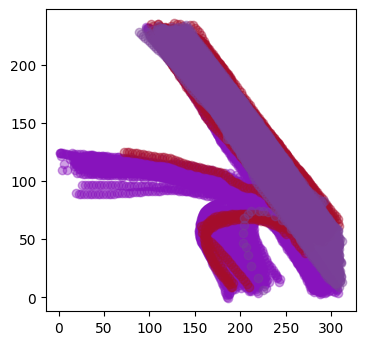

In [29]:
#利用silhouette_score只用5轮迭代选取最优聚类k
best_k = 2
score = -1
distance_mat=np.load("VMT_dis_mat.npy")
m, n = distance_mat.shape
print(m,n)
final_labels = np.zeros((m,))
final_C = []
for k in range(3,8):
    M, C = KMeans(tracks, k,3)
    print('k=',k,'done')
    labels = np.zeros((m,))
    for i in range(k):
        for index in C[i]:
            labels[index] = i
    score_tmp = metrics.silhouette_score(distance_mat, labels)
    if score_tmp > score:
        best_k = k
        final_labels = labels
        score = score_tmp
        final_C = C
print("The best k: {0}, its silhouette_score: {1}".format(best_k, score))
alph=0.4
fig=plt.figure(figsize=(4,4),dpi=100) 
ax=plt.gca()
label_color=[]
for i in range(20):
    label_color+=[[np.random.random(),np.random.random(),np.random.random(),alph],]
ax.cla()
for label_idx in range(best_k):
    for t_idx in C[label_idx]:
        ax.scatter(tracks[t_idx][0], tracks[t_idx][1], color=label_color[label_idx+1])
plt.show()
fig.savefig(f"best_k={best_k}训练着色.png")


The best k: 3
iteration 0 beginning
iteration 1 beginning
iteration 2 beginning
iteration 3 beginning
iteration 4 beginning
ari: 0.26622557939246033
nmi: 0.570929152707927


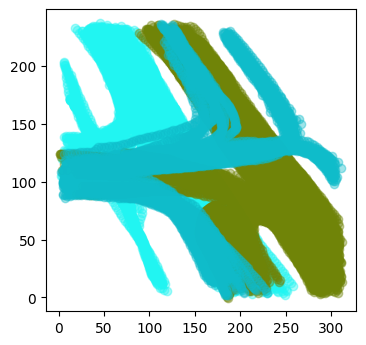

In [30]:
#最终用best_k跑更多轮迭代
print("The best k: {0}".format(best_k))
distance_mat=np.load("VMT_dis_mat.npy")
m, n = distance_mat.shape
num_iter=10#迭代轮数
M, C= KMeans(tracks, k=best_k,tmax=num_iter)
labels = np.zeros((m,))
for i in range(best_k):
    for index in C[i]:
        labels[index] = i
labels_true = labels_true.flatten()
labels = labels.flatten()
nmi = normalized_mutual_info_score(labels_true,labels)
ari = metrics.adjusted_rand_score(labels_true=labels_true, labels_pred=labels)
print('ari:',ari)
print('nmi:',nmi)

alph=0.4
fig=plt.figure(figsize=(4,4),dpi=100) 
ax=plt.gca()
label_color=[]
for i in range(20):
    label_color+=[[np.random.random(),np.random.random(),np.random.random(),alph],]
ax.cla()
for label_idx in range(best_k):
    for t_idx in C[label_idx]:
        ax.scatter(tracks[t_idx][0], tracks[t_idx][1], color=label_color[label_idx+1])
plt.show()
fig.savefig(f"best_k={best_k}时{num_iter}轮迭代着色.png")